In [1]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.0 MB/s eta 0:00:00


In [3]:
import pandas as pd

small_file_path = "/content/drive/MyDrive/dataset/424_F2024_Final_PC_small_train_v1.csv"
large_file_path = "/content/drive/MyDrive/dataset/424_F2024_Final_PC_large_train_v1.csv"

small_df = pd.read_csv(small_file_path)
large_df = pd.read_csv(small_file_path)

data = pd.concat([small_df, large_df], ignore_index=True)
data.to_csv("/content/drive/MyDrive/dataset/combined_data.csv", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading and preprocessing data...
Tokenizing texts...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Creating and compiling model...


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Training model...
Epoch 1/3
4500/4500 [==============================] - 1153s 242ms/step - loss: 0.0431 - val_loss: 0.0514
Epoch 2/3
4500/4500 [==============================] - 1081s 240ms/step - loss: 0.0510 - val_loss: 0.0510
Epoch 3/3
4500/4500 [==============================] - 1081s 240ms/step - loss: 0.0519 - val_loss: 0.0498
Saving model to /content/drive/MyDrive/dataset/bert_model.keras...


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model saved successfully!
Making predictions...
1250/1250 [==============================] - 94s 72ms/step
MSE (normalized scale): 0.0499
R² (normalized scale): -0.0015
MSE (original scale 1-5): 1.2479
R² (original scale 1-5): -0.0015


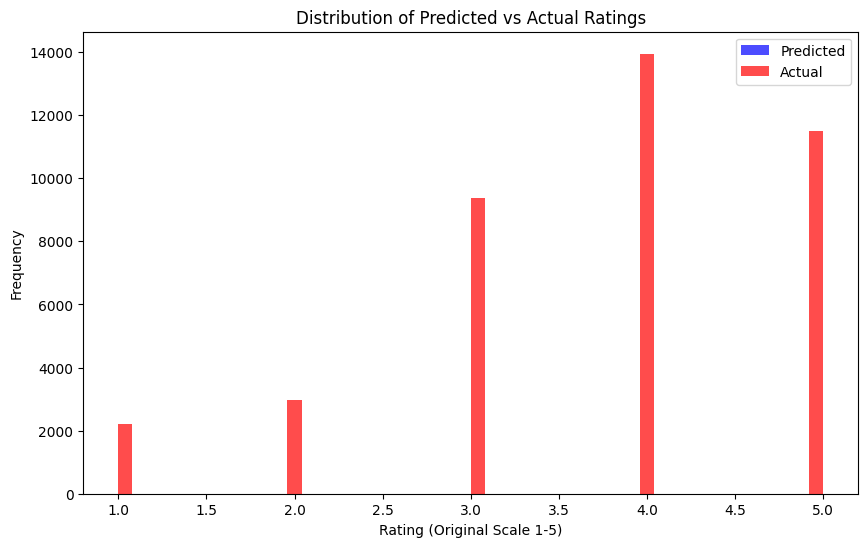

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 16 14:31:49 2024

@author: jeongwoohong
"""
import pandas as pd
import numpy as np
import tensorflow as tf
import contractions
import re
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import os

# Download required NLTK data
nltk.download('stopwords')

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def preprocess_text(text):
    """Enhanced text preprocessing"""
    text = str(text).lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove special characters but keep important punctuation
    text = re.sub(r'[^a-zA-Z\s\.,!?]', ' ', text)

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Keep negative words that might be important for sentiment
    negative_words = {'no', 'not', 'nor', 'neither', 'never', 'none'}
    stop_words = stop_words - negative_words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text.strip()

def normalize_rating(rating):
    """Convert ratings from 1-5 to 0-1"""
    return rating * 0.2

def denormalize_rating(normalized_rating):
    """Convert ratings from 0-1 back to 1-5"""
    return np.clip(normalized_rating * 5, 1, 5)

# Load and preprocess the data
def prepare_data(data):
    # Read CSV file
    df = data

    # Concatenate text columns and preprocess
    df['combined_text'] = df['headline'] + ' ' + df['pros'] + ' ' + df['cons']
    df['processed_text'] = df['combined_text'].apply(preprocess_text)

    # Normalize ratings
    df['normalized_rating'] = df['rating'].apply(normalize_rating)

    return df

# BERT tokenization
def tokenize_texts(texts, max_length=128):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

# Create BERT model
def create_model(max_length=128):
    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # Load BERT
    bert = TFBertModel.from_pretrained('bert-large-uncased')

    # Get BERT embeddings
    bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = bert_outputs[1]

    # Add few dense layers
    x = tf.keras.layers.Dropout(0.3)(pooled_output)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


    # Create model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)

    return model

# Main execution function
def main(data):
    print("Loading and preprocessing data...")
    df = prepare_data(data)

    # Split data
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['processed_text'],
        df['normalized_rating'],
        test_size=0.2,
        random_state=42
    )

    print("Tokenizing texts...")
    train_encodings = tokenize_texts(train_texts)
    test_encodings = tokenize_texts(test_texts)

    # Create model
    print("Creating and compiling model...")
    model = create_model()

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss='mse')

    # Train model
    print("Training model...")
    history = model.fit(
        {
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_labels,
        epochs=3,
        batch_size=32,
        validation_split=0.1
    )

    # Save the model
    save_path = "/content/drive/MyDrive/dataset/bert_model.keras"
    print(f"Saving model to {save_path}...")
    model.save(save_path)
    print("Model saved successfully!")

    # Make predictions
    print("Making predictions...")
    normalized_predictions = model.predict({
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    })

    # Convert predictions and test labels back to original scale (1-5)
    predictions_original_scale = denormalize_rating(normalized_predictions)
    test_labels_original_scale = denormalize_rating(test_labels)

    # Calculate metrics using normalized values (for consistency with training)
    mse = mean_squared_error(test_labels, normalized_predictions)
    r2 = r2_score(test_labels, normalized_predictions)

    print(f"MSE (normalized scale): {mse:.4f}")
    print(f"R² (normalized scale): {r2:.4f}")

    # Calculate metrics in original scale
    mse_original = mean_squared_error(test_labels_original_scale, predictions_original_scale)
    r2_original = r2_score(test_labels_original_scale, predictions_original_scale)

    print(f"MSE (original scale 1-5): {mse_original:.4f}")
    print(f"R² (original scale 1-5): {r2_original:.4f}")

    # Plot histogram of predictions in original scale
    plt.figure(figsize=(10, 6))
    plt.hist(predictions_original_scale, bins=50, alpha=0.7, color='blue', label='Predicted')
    plt.hist(test_labels_original_scale, bins=50, alpha=0.7, color='red', label='Actual')
    plt.xlabel('Rating (Original Scale 1-5)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted vs Actual Ratings')
    plt.legend()
    plt.show()

    return model

# Example usage
if __name__ == "__main__":
    model = main(data)

In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk
from nltk.corpus import stopwords
import contractions
import re

# NLTK stopwords download
nltk.download('stopwords')

def preprocess_text(text):
    text = str(text).lower()
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z\s\.,!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    stop_words = set(stopwords.words('english'))
    negative_words = {'no', 'not', 'nor', 'neither', 'never', 'none'}
    stop_words = stop_words - negative_words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text.strip()

def tokenize_texts(texts, max_length=128):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

def batch_predict(serving_fn, test_encodings, batch_size=32):
    input_ids = test_encodings['input_ids']
    attention_mask = test_encodings['attention_mask']
    num_samples = input_ids.shape[0]

    predictions = []
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_input_ids = input_ids[start_idx:end_idx]
        batch_attention_mask = attention_mask[start_idx:end_idx]

        # Predict for the batch
        batch_predictions = serving_fn(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask
        )['dense_5'].numpy().flatten()

        predictions.extend(batch_predictions)

    return np.array(predictions)

def main(saved_model_path, test_file_path, output_csv_path, max_length=128, batch_size=32):
    print("Loading the saved model...")
    model = tf.saved_model.load(saved_model_path)
    serving_fn = model.signatures["serving_default"]

    print("Loading and preprocessing test data...")
    test_data = pd.read_csv(test_file_path)
    test_data['combined_text'] = test_data['headline'] + ' ' + test_data['pros'] + ' ' + test_data['cons']
    test_data['processed_text'] = test_data['combined_text'].apply(preprocess_text)

    print("Tokenizing test data...")
    test_encodings = tokenize_texts(test_data['processed_text'], max_length=max_length)

    print("Making predictions in batches...")
    predictions = batch_predict(serving_fn, test_encodings, batch_size=batch_size)
    predicted_ratings = np.clip(predictions * 5, 1, 5)

    print("Saving predictions to CSV...")
    # Save only the predicted ratings
    pd.DataFrame({'predicted_rating': predicted_ratings}).to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

    return predicted_ratings

saved_model_path = "/content/drive/MyDrive/dataset/bert_model"
test_file_path = "/content/drive/MyDrive/dataset/424_F2024_Final_PC_small_train_v1.csv"
output_csv_path = "/content/drive/MyDrive/dataset/predicted_ratings_small.csv"

if __name__ == "__main__":
    result = main(saved_model_path, test_file_path, output_csv_path, max_length=128, batch_size=32)
    print("Sample predictions:", result[:5])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading the saved model...
Loading and preprocessing test data...
Tokenizing test data...
Making predictions in batches...
Saving predictions to CSV...
Predictions saved to /content/drive/MyDrive/dataset/predicted_ratings_small.csv
Sample predictions: [3.5280993 4.6547327 4.4127493 4.3735037 3.222022 ]


In [12]:
print(result)

import numpy as np

# Example array
predicted_ratings = result

# Save to CSV
np.savetxt("predicted_ratings.csv", predicted_ratings, delimiter=",", header="predicted_rating", comments="")


[2.728287  4.57788   4.934897  ... 3.7183592 2.902059  4.4113884]
